## Model Training Framework for PLC-Compatible LSTM Models  

This module is part of the research project:  

**_“Towards AI-Based Anomaly Detection at the Edge:  
Evaluating Real-Time Cyber Defense in Programmable Logic Controllers”_**  

The implementation defines a **deterministic training workflow** for LSTM-based anomaly detection models designed for deployment in **Programmable Logic Controllers (PLCs)**.  
It ensures **reproducible experiments** and **consistent parameter management** between the training and export stages.  

All random generators (`torch`, `numpy`, `random`) are seeded for full determinism.  
The dataset is preprocessed through **feature selection, normalization, and time-windowed batching** for sequence learning.  

The training process uses an **autoencoder-based LSTM** that reconstructs the last timestep of each input window.  
The system includes **early stopping**, **calibration-based thresholding**, and **automatic checkpoint saving** per epoch.

---

## User Guide — Training Configuration and Execution  

Only minimal configuration is required before training.  
The training script automatically creates the model directory and saves all logs, checkpoints, and normalization references.

---

### Step 1: Configure Model Parameters  

### Step 1: Configure Model Parameters  

Before running the script, set these constants according to the trained model you want to export:

```python
MODEL_NAME = "LSTM_SWaT"
MODEL_VERSION = "v1"
HIDDEN_SIZE = 8
SEQUENCE_LENGTH = 10
BEST_EPOCH = 2
```

The base paths are defined dynamically in the script to ensure consistent folder structure:

```python
BASE_DIR = Path.cwd()
PROJECT_DIR = BASE_DIR.parent
DATASET_DIR = PROJECT_DIR / "dataset"
```

This logic automatically links the working directory to the project’s parent folder and the dataset location.  
These paths are **only templates** — users may **freely modify** them to match their own project structure.  
The important point is that the script always builds file references **relative to a defined project root**,  
so all models, datasets, and export files remain organized and traceable.

When execution begins, the program constructs the model export directory:

```
MODEL_DIR = /Models/HS8_IW10_v1/
```

- If this folder **does not exist**, it is **automatically created**.  
- If it **already exists**, the user is prompted to confirm overwriting.  
  - Selecting **“Yes”** allows file replacement.  
  - Selecting **“No”** cancels execution and safely shuts down the notebook kernel.

This setup gives users flexibility in organizing their project while ensuring safe and reproducible operation.



### Step 2: Run Training  

Run the notebook manually (avoid “Run All”).  
Confirm overwrite if the target model directory already exists.  
The script will automatically:
- Load and preprocess the dataset  
- Split it into train/calibration/test sets (60/20/20)  
- Normalize all features using Z-score  
- Train the LSTM autoencoder  
- Save checkpoints, normalization data, and logs  

No additional manual actions are required during training.

---

### Step 3: Check Results  

After completion, verify that the following files exist in the model folder:
The exact filenames depend on the user-defined configuration parameters
(e.g., model name, hidden size, input window, version, and epoch).

Example output files:

```
/Models/HS8_IW10_v1/
│
├── LSTM_SWaT_HS8_IW10_v1_Epoch_01.pt
├── LSTM_SWaT_HS8_IW10_v1_Epoch_02.pt
├── LSTM_SWaT_HS8_IW10_v1_featureNormRef_.csv
├── LSTM_SWaT_HS8_IW10_v1_Learning_LOG.csv
└── loss_plots.png  (optional)
```


## Legal Notice

- Author: Zoltán Dobrády  
- Website: www.cyberseclab.eu  
- Contact: zoltan.dobrady@hotmail.com  
- License: Creative Commons BY-NC 4.0  
- Version: v1.0.1 
- Copyright: © 2025-2026

This software is for educational and research purposes only or other non-commercial use.  
Use in an industrial environment is forbidden.  
The author must be credited in all use cases.  
Commercial use requires written permission.

---


## Important Notice

**Do NOT use Run All**.

This notebook requires an explicit user confirmation step. Run cells manually after confirmation.

---

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
import os, threading
from sklearn.preprocessing import StandardScaler
from IPython import get_ipython
import random
import csv
BASE_DIR = Path.cwd()
PROJECT_DIR = BASE_DIR.parent
DATASET_DIR = PROJECT_DIR / "dataset"

In [2]:
HIDDEN_SIZE = 8
SEQUENCE_LENGTH = 10
MODEL_NAME = "LSTM_SWaT"
MODEL_VERSION = "v1"
NUM_EPOCHS = 1
EARLY_STOPPING_PATIENCE = 10

In [3]:
MODEL_FILENAME = f"{MODEL_NAME}_HS{HIDDEN_SIZE}_IW{SEQUENCE_LENGTH}_{MODEL_VERSION}.pt"
MODEL_DIR = f"{PROJECT_DIR}/Models/HS{HIDDEN_SIZE}_IW{SEQUENCE_LENGTH}_{MODEL_VERSION}"
NORM_REFERENCE_FILENAME = f"{MODEL_NAME}_HS{HIDDEN_SIZE}_IW{SEQUENCE_LENGTH}_{MODEL_VERSION}_featureNormRef_.csv"
LEARN_DATA_FILENAME = "SWaT_Dataset_Normal_v0.csv"

DROPOUT = 0.0
NUM_LAYERS = 1
BATCH_SIZE = 32 
THRESHOLD_PERCENTILE = 92
LEARNING_RATE = 0.001
STRIDE = 1
SEED = 42

In [4]:
USER_CONFIRMED_OVERWRITE = False
out = widgets.Output()
if os.path.exists(MODEL_DIR):
    print(f"[WARNING] Directory already exists at: {MODEL_DIR}")
    print("Press YES to continue or NO to stop execution.")

    yes_button = widgets.Button(description="Yes", button_style="danger")
    no_button  = widgets.Button(description="No", button_style="success")

    def on_yes_clicked(b):
        global USER_CONFIRMED_OVERWRITE
        USER_CONFIRMED_OVERWRITE = True
        with out:
            out.clear_output()
            print("[WARNING] Existing files in this directory may be OVERWRITTEN!")

    def on_no_clicked(b):
        with out:
            out.clear_output()
            print("[ABORTED] User cancelled execution.")
        get_ipython().kernel.do_shutdown(restart=False)

    yes_button.on_click(on_yes_clicked)
    no_button.on_click(on_no_clicked)

    display(widgets.HBox([yes_button, no_button]))
    display(out)

else:
    USER_CONFIRMED_OVERWRITE = True
    os.makedirs(MODEL_DIR)
    print(f"[INFO] Directory created at: {MODEL_DIR}")

[INFO] Directory created at: c:\Repos\Towards-AI-Based-Anomaly-Detection-at-the-Edge-Evaluating-Real-Time-CyberDefense-in-PLC/Models/HS8_IW10_v1


In [5]:
if os.path.exists(MODEL_DIR) and not USER_CONFIRMED_OVERWRITE:
    print("[ABORTED] No user confirmation received. Stopping execution.")
    get_ipython().kernel.do_shutdown(restart=False)

In [6]:
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
# --- 1. Load and Inspect Data ---
df = pd.read_csv(os.path.join(DATASET_DIR, LEARN_DATA_FILENAME), encoding='utf-8-sig', header=1)
df.columns = df.columns.str.strip()

# --- 2. Model candidate features: numeric columns ---
numeric_df = df.select_dtypes(include='number')
numeric_columns = numeric_df.columns.tolist()

# --- 3. Non-numeric columns (meta, timestamp, or labels) ---
non_numeric_columns = [col for col in df.columns if col not in numeric_columns]

# --- 4. Exclude constant (uninformative) numeric features ---
min_row = numeric_df.min()
max_row = numeric_df.max()
status_row = np.where((max_row - min_row) == 0, 'CONST', 'VALID')
transposed_df = pd.DataFrame(
    [min_row.values, max_row.values, status_row],
    columns=min_row.index,
    index=['Min', 'Max', 'Status']
)
features_for_model = transposed_df.columns[transposed_df.loc['Status'] == 'VALID'].tolist()
constant_numeric_columns = transposed_df.columns[transposed_df.loc['Status'] == 'CONST'].tolist()

print(f"Model candidate input features: {len(numeric_columns)}")
print(numeric_columns)
print(f"\nDiscarded non-numeric columns: {len(non_numeric_columns)}")
print(non_numeric_columns)
print(f"\nDiscarded constant numeric columns: {len(constant_numeric_columns)}")
print(constant_numeric_columns)
print(f"\nFinal model input features (non-constant): {len(features_for_model)}")
print(features_for_model)
print(f"\nTotal samples before removing missing values: {len(df)}")

Model candidate input features: 51
['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603']

Discarded non-numeric columns: 2
['Timestamp', 'Normal/Attack']

Discarded constant numeric columns: 11
['P102', 'P201', 'P202', 'P204', 'P206', 'P401', 'P403', 'P404', 'P502', 'P601', 'P603']

Final model input features (non-constant): 40
['FIT101', 'LIT101', 'MV101', 'P101', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'MV201', 'P203', 'P205', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P402', 'UV401', 'AIT501', 'AIT

In [8]:
# --- 5. Remove samples with missing values in model input features ---
missing_mask = df[features_for_model].isnull().any(axis=1)
n_missing = missing_mask.sum()
print(f"Samples with missing input features (removed): {n_missing}")
df_clean = df[~missing_mask].copy()
print(f"Total samples after removing missing values: {len(df_clean)}")

Samples with missing input features (removed): 0
Total samples after removing missing values: 496800


In [9]:
# --- 6. Train / Calib(threshold) / Test Split (időrendi) ---
n = len(df_clean)
train_end = int(n * 0.6)
calib_end = int(n * 0.8)

train_df = df_clean.iloc[:train_end].copy()
calib_df = df_clean.iloc[train_end:calib_end].copy()   
test_df  = df_clean.iloc[calib_end:].copy()            

# --- 7. Z-score normalization ---
scaler = StandardScaler()
train_df[features_for_model] = scaler.fit_transform(train_df[features_for_model])
calib_df[features_for_model] = scaler.transform(calib_df[features_for_model])
test_df[features_for_model]  = scaler.transform(test_df[features_for_model])

# --- 8. Check normalization correctness 
mean_tolerance = 1e-2  
std_tolerance = 1e-2   

means = train_df[features_for_model].mean()
stds = train_df[features_for_model].std()

bad_means = means[np.abs(means) > mean_tolerance]
bad_stds = stds[np.abs(stds - 1) > std_tolerance]

if not bad_means.empty or not bad_stds.empty:
    print("WARNING: Train features were not properly normalized.")
    if not bad_means.empty:
        print("Features with mean significantly different from 0:")
        print(bad_means)
    if not bad_stds.empty:
        print("Features with std significantly different from 1:")
        print(bad_stds)
else:
    print("Z-score normalization check: All TRAIN features normalized successfully.")
    
NUM_CLASSES = len(features_for_model)
print("Model input/output dim (NUM_CLASSES):", NUM_CLASSES)

Z-score normalization check: All TRAIN features normalized successfully.
Model input/output dim (NUM_CLASSES): 40


In [10]:
# --- 9. Dataset and DataLoader Preparation ---
class TempDataset(Dataset):
    def __init__(self, data, seq_len, features, stride=1):
        self.data = data[features].values.astype('float32')
        self.seq_len = seq_len
        self.stride = stride

    def __len__(self):
        return (len(self.data) - self.seq_len) // self.stride + 1

    def __getitem__(self, idx):
        start = idx * self.stride
        end = start + self.seq_len
        seq = self.data[start:end, :]
        return torch.from_numpy(seq)

train_dataset = TempDataset(train_df, SEQUENCE_LENGTH, features_for_model, stride=STRIDE)
calib_dataset = TempDataset(calib_df, SEQUENCE_LENGTH, features_for_model, stride=STRIDE)
test_dataset  = TempDataset(test_df,  SEQUENCE_LENGTH, features_for_model, stride=STRIDE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
calib_loader = DataLoader(calib_dataset, batch_size=1, shuffle=False)  # early stop + threshold
test_loader  = DataLoader(test_dataset,  batch_size=1, shuffle=False)  # érintetlen mérés

# --- 10. Model Definition ---
class TempLSTMAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, sequence_length):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)
        self.sequence_length = sequence_length  # csak tárolás

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size, device=x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size, device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        y = self.fc(out[:, -1, :])  # (B, F)
        return y

###Train and create the model


Epoch 01 | Train Loss: 0.237902 | Calib Loss: 0.099954


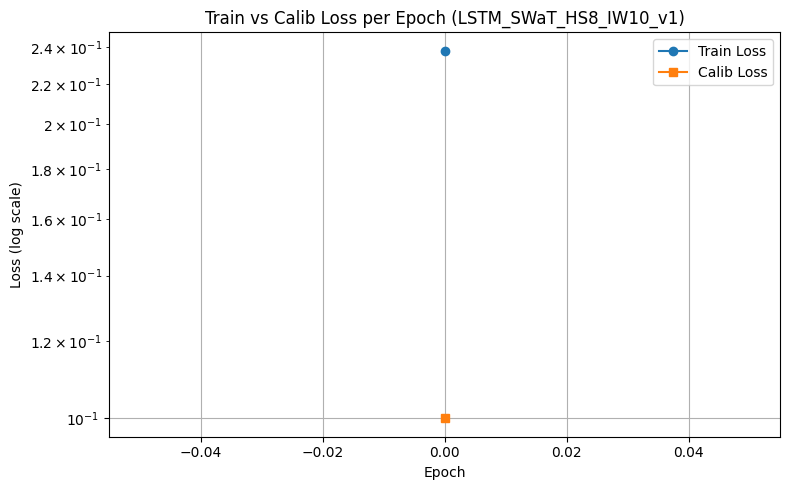

Prediction threshold (MSE, 92 percentile) FROM CALIB: 0.252103


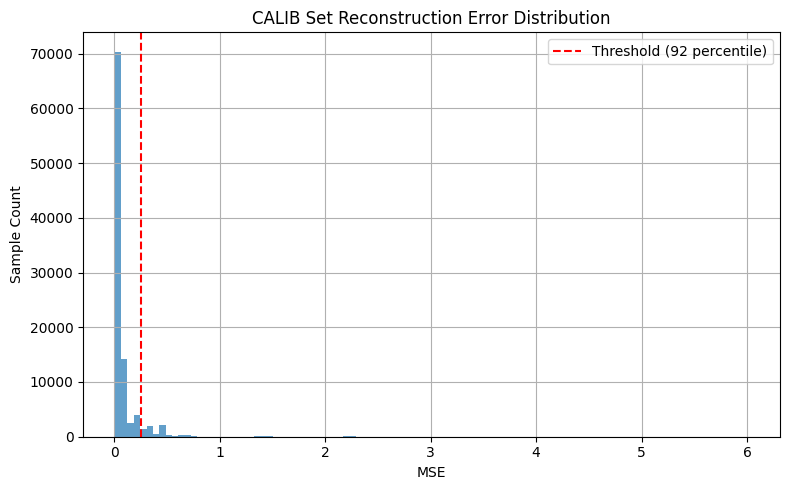

Model, and normalization parameters saved: c:\Repos\Towards-AI-Based-Anomaly-Detection-at-the-Edge-Evaluating-Real-Time-CyberDefense-in-PLC/Models/HS8_IW10_v1/LSTM_SWaT_HS8_IW10_v1_Epoch_01.pt


In [11]:
# --- 11. Training ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TempLSTMAutoencoder(
    input_size=NUM_CLASSES,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    sequence_length=SEQUENCE_LENGTH
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

early_stopping_patience = EARLY_STOPPING_PATIENCE
best_loss = float('inf')
epochs_without_improvement = 0

train_loss_history = []
calib_loss_history = []

for epoch in range(NUM_EPOCHS):
    # MODEL TRAINING PHASE
    model.train()
    total_train_loss = 0.0

    for inputs in train_loader:
        inputs = inputs.to(device)

        target = inputs[:, -1, :]      
        outputs = model(inputs)        
        loss = criterion(outputs, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * inputs.size(0)

    avg_train_loss = total_train_loss / len(train_dataset)
    train_loss_history.append(avg_train_loss)

    # --- CALIBRATION/VALIDATION PHASE/EARLY STOP ---
    model.eval()
    total_calib_loss = 0.0
    with torch.no_grad():
        for inputs in calib_loader:
            inputs = inputs.to(device)
            target = inputs[:, -1, :]
            outputs = model(inputs)
            loss = criterion(outputs, target)
            total_calib_loss += loss.item() * inputs.size(0)

    avg_calib_loss = total_calib_loss / len(calib_dataset)
    calib_loss_history.append(avg_calib_loss)

    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.6f} | Calib Loss: {avg_calib_loss:.6f}")

    # --- SAVE MODEL FOR EACH EPOCH ---
    model_path = f"{MODEL_DIR}/{MODEL_NAME}_HS{HIDDEN_SIZE}_IW{SEQUENCE_LENGTH}_{MODEL_VERSION}_Epoch_{epoch+1:02d}.pt"
    torch.save(model.state_dict(), model_path)

    # --- EARLY STOPPING (based on CALIB loss) ---
    if avg_calib_loss < best_loss:
        best_loss = avg_calib_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# --- 12. Loss Visualization ---
plt.figure(figsize=(8, 5))
plt.plot(train_loss_history, label='Train Loss', marker='o')
plt.plot(calib_loss_history, label='Calib Loss', marker='s')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title(f'Train vs Calib Loss per Epoch ({MODEL_NAME}_HS{HIDDEN_SIZE}_IW{SEQUENCE_LENGTH}_{MODEL_VERSION})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 13. Calculate THRESHOLD on CALIB dataset ---
calib_loader = DataLoader(
    calib_dataset,
    batch_size=256,   # adjust if needed
    shuffle=False,
    pin_memory=True
)
model.eval()
mse_calib = []

with torch.no_grad():
    for inputs in calib_loader:
        inputs = inputs.to(device, non_blocking=True)

        targets = inputs[:, -1, :]     # (B, F)
        outputs = model(inputs)        # (B, F)

        mse = ((targets - outputs) ** 2).mean(dim=1)  # (B,)
        mse_calib.append(mse)

mse_calib = torch.cat(mse_calib).cpu().numpy()
pred_threshold = np.percentile(mse_calib, THRESHOLD_PERCENTILE)
threshold_percentile = THRESHOLD_PERCENTILE
pred_threshold = np.percentile(mse_calib, threshold_percentile)
print(f"Prediction threshold (MSE, {threshold_percentile} percentile) FROM CALIB: {pred_threshold:.6f}")

plt.figure(figsize=(8, 5))
plt.hist(mse_calib, bins=100, alpha=0.7)
plt.axvline(pred_threshold, color='red', linestyle='--',
            label=f'Threshold ({threshold_percentile} percentile)')
plt.title('CALIB Set Reconstruction Error Distribution')
plt.xlabel('MSE')
plt.ylabel('Sample Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 14. Save LEARNING LOG to CSV (loss history + key training params) ---
learning_log_path = os.path.join(
    MODEL_DIR,
    f"{MODEL_NAME}_HS{HIDDEN_SIZE}_IW{SEQUENCE_LENGTH}_{MODEL_VERSION}_Learning_LOG.csv"
)

loss_header = ["Epoch", "Train_Loss", "Calib_Loss"]
loss_rows = list(zip(
    range(1, len(train_loss_history) + 1),
    train_loss_history,
    calib_loss_history
))

param_header = [
    "LEARNING_RATE",
    "EARLY_STOPPING_PATIENCE",
    "NUM_LAYERS",
    "HIDDEN_SIZE",
    "SEQUENCE_LENGTH",
    "BATCH_SIZE",
    "DROPOUT",
    "SEED",
    "THRESHOLD_PERCENTILE",
    "BEST_CALIB_LOSS",
    "EPOCHS_RAN",
    "DEVICE",
    "STRIDE",
]
param_values = [
    LEARNING_RATE,
    EARLY_STOPPING_PATIENCE,
    NUM_LAYERS,
    HIDDEN_SIZE,
    SEQUENCE_LENGTH,
    BATCH_SIZE,
    DROPOUT,
    SEED,
    THRESHOLD_PERCENTILE,
    best_loss,
    len(train_loss_history),
    str(device),
    STRIDE,
]
with open(learning_log_path, "w", newline="") as f:
    w = csv.writer(f)
    #params section
    w.writerow(param_header)
    w.writerow(param_values)
    # Loss section
    w.writerow([])
    w.writerow(loss_header)
    w.writerows(loss_rows)

# --- 15. Save model and normalization parameters with logs ---
dummy_input = torch.randn(1, SEQUENCE_LENGTH, NUM_CLASSES).to(device)
model.eval()
with torch.no_grad():
    _ = model(dummy_input)

# Save normalization parameters
scaler_df = pd.DataFrame({'mean': scaler.mean_, 'std': scaler.scale_}, index=features_for_model)
scaler_df.to_csv(os.path.join(MODEL_DIR, NORM_REFERENCE_FILENAME))

# Save full model
torch.save(model, os.path.join(MODEL_DIR, MODEL_FILENAME))
print(f"Model, and normalization parameters saved: {model_path}")
